# Sequence-to-sequence activity recognition

In [1]:
# !pip3 install wandb

In [2]:
# !pip3 install git+https://github.com/tensorflow/addons.git

In [3]:
from tensorflow.keras.layers import Add, Dense, Dropout, MultiHeadAttention, LayerNormalization, Layer, Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, Callback, ModelCheckpoint
from tensorflow.keras.utils import plot_model,Sequence
from tensorflow_addons.optimizers import AdamW
from wandb.keras import WandbCallback
from sklearn.model_selection import train_test_split 
# from sklern.metric.preprocessing import StandardScaler
import math
import wandb
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy

c:\Users\bsa\Anaconda3\envs\shl2023\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
# パス（相対パスで書くこと。他の環境でも動作させるため。）
OUTPUT_DIR = '../output/model/transformer/'
MODEL_OUT = '0606'
# TRAINING_PATH = '../data/every_5s_normalized/train/'
# VAL_PATH = '../data/every_5s_normalized/validate/'
# TEST_PATH = '../data/every_5s_normalized/test/'
# POS = 'Hand'
# FILENAME_ACC = "Acc_every_5s.npy"
# FILENAME_GYR = "Gyr_every_5s.npy"
# FILENAME_MAG = "Mag_every_5s.npy"
# FILENAME_LABEL = 'Label_every_5s.npy'

## Init logger

In [5]:
# wandb.login()

sweep_config = {
  'method': 'grid',
  'metric': {
    'goal': 'maximize',
    'name': 'val_accuracy'
  },
  'parameters': {
      'epochs': {
        'value': 50
      },
      'num_layers': {
        'value': 3
      },
      'embed_layer_size': {
        'value': 128
      },
      'fc_layer_size': {
        'value': 256
      },
      'num_heads': {
        'value': 6
      },
      'dropout': {
        'value': 0.1
      },
      'attention_dropout': {
        'value': 0.1
      },
      'optimizer': {
        'value': 'adam'
      },
      'amsgrad': {
        'value': False
      },
      'label_smoothing': {
        'value': 0.1
      },
      'learning_rate': {
        'value': 1e-3
      },
      #'weight_decay': {
      #    'values': [2.5e-4, 1e-4, 5e-5, 1e-5]
      #},
      'warmup_steps': {
        'value': 10
      },
      'batch_size': {
        'value': 64
      },
      'global_clipnorm': {
        'value': 3.0
      },
    }
}

# sweep_id = wandb.sweep(sweep_config, project="HAR-Transformer")


## Layer

In [6]:
class PositionalEmbedding(Layer):
    def __init__(self, units, dropout_rate, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)

        self.units = units

        self.projection = Dense(units, kernel_initializer=TruncatedNormal(stddev=0.02))

        self.dropout = Dropout(rate=dropout_rate)

    def build(self, input_shape):
        super(PositionalEmbedding, self).build(input_shape)

        self.position = self.add_weight(
            name="position",
            shape=(1, input_shape[1], self.units),
            initializer=TruncatedNormal(stddev=0.02),
            trainable=True,
        )

    def call(self, inputs, training):
        x = self.projection(inputs)
        x = x + self.position

        return self.dropout(x, training=training)


In [7]:
class Encoder(Layer):
    def __init__(
        self, embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate, **kwargs
    ):
        super(Encoder, self).__init__(**kwargs)

        self.mha = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=attention_dropout_rate,
            kernel_initializer=TruncatedNormal(stddev=0.02),
        )

        self.dense_0 = Dense(
            units=mlp_dim,
            activation="gelu",
            kernel_initializer=TruncatedNormal(stddev=0.02),
        )
        self.dense_1 = Dense(
            units=embed_dim, kernel_initializer=TruncatedNormal(stddev=0.02)
        )

        self.dropout_0 = Dropout(rate=dropout_rate)
        self.dropout_1 = Dropout(rate=dropout_rate)

        self.norm_0 = LayerNormalization(epsilon=1e-5)
        self.norm_1 = LayerNormalization(epsilon=1e-5)

        self.add_0 = Add()
        self.add_1 = Add()

    def call(self, inputs, training):
        # Attention block
        x = self.norm_0(inputs)
        x = self.mha(
            query=x,
            value=x,
            key=x,
            training=training,
        )
        x = self.dropout_0(x, training=training)
        x = self.add_0([x, inputs])

        # MLP block
        y = self.norm_1(x)
        y = self.dense_0(y)
        y = self.dense_1(y)
        y = self.dropout_1(y, training=training)

        return self.add_1([x, y])


## Model

In [8]:
class Transformer(Model):
    def __init__(
        self,
        num_layers,
        embed_dim,
        mlp_dim,
        num_heads,
        num_classes,
        dropout_rate,
        attention_dropout_rate,
        **kwargs
    ):
        super(Transformer, self).__init__(**kwargs)

        # Input (normalization of RAW measurements)
        self.input_norm = Normalization()

        # Input
        self.pos_embs = PositionalEmbedding(embed_dim, dropout_rate)

        # Encoder
        self.e_layers = [
            Encoder(embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate)
            for _ in range(num_layers)
        ]

        # Output
        self.norm = LayerNormalization(epsilon=1e-5)
        self.final_layer = Dense(num_classes, kernel_initializer="zeros")

    def call(self, inputs, training):
        x = self.input_norm(inputs)
        x = self.pos_embs(x, training=training)

        for layer in self.e_layers:
            x = layer(x, training=training)

        x = self.norm(x)
        x = self.final_layer(x)

        return x


## Loss

In [9]:
def smoothed_sparse_categorical_crossentropy(label_smoothing: float = 0.0):
    def loss_fn(y_true, y_pred):
        num_classes = tf.shape(y_pred)[-1]
        y_true = tf.one_hot(y_true, num_classes)

        loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True, label_smoothing=label_smoothing)
        return tf.reduce_mean(loss)

    return loss_fn

## LR scheduler

In [10]:
def cosine_schedule(base_lr, total_steps, warmup_steps):
    def step_fn(epoch):
        lr = base_lr
        epoch += 1

        progress = (epoch - warmup_steps) / float(total_steps - warmup_steps)
        progress = tf.clip_by_value(progress, 0.0, 1.0)
        
        lr = lr * 0.5 * (1.0 + tf.cos(math.pi * progress))

        if warmup_steps:
            lr = lr * tf.minimum(1.0, epoch / warmup_steps)

        return lr

    return step_fn



In [11]:
class PrintLR(Callback):
    def on_epoch_end(self, epoch, logs=None):
        wandb.log({"lr": self.model.optimizer.lr.numpy()}, commit=False)

## Dataset

In [12]:
def load_data(type):
    TRAINING_PATH = '../data/every_5s/train/'
    VAL_PATH = '../data/every_5s/validate/'
    TEST_PATH = '../data/every_5s/test/'
    POS = 'Hand'
    FILENAME_ACC = "Acc_every_5s.npy"
    FILENAME_GYR = "Gyr_every_5s.npy"
    FILENAME_MAG = "Mag_every_5s.npy"
    FILENAME_LABEL = 'Label_every_5s.npy'
    TYPE = ['train','test','validate']
    if type == 'train':
        dir = TRAINING_PATH
    elif type == 'validate':
        dir = VAL_PATH
    elif type == 'test':
        dir = TEST_PATH
    else:
        print('type is not valid.')
        return
    acc = np.load(os.path.join(dir,POS,FILENAME_ACC))[:,:,1:]
    gyr = np.load(os.path.join(dir,POS,FILENAME_GYR))[:,:,1:]
    mag = np.load(os.path.join(dir,POS,FILENAME_MAG))[:,:,1:]
    
    y = np.load(os.path.join(dir,FILENAME_LABEL))[:,:,1:].squeeze().astype('uint8')-1 if type != 'test' else None
    X = np.concatenate([acc,gyr,mag],axis=2).astype('float32')
    # print(X.shape,y.shape)
    return X,y

In [13]:
CLASS_LABELS = np.array(
    ['Still', 'Walking', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']
)

# load dataset
X_train,y_train = load_data('train')
X_val,y_val = load_data('validate')
print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)


(190037, 500, 9) (190037, 500)
(21650, 500, 9) (21650, 500)


[11863500 11608000  3789500 11692000 15759000 13993000 15476500 10837000]
<class 'numpy.uint8'>
[2127000 1896000   59500  964000 1541000  644000 1425500 2168000]


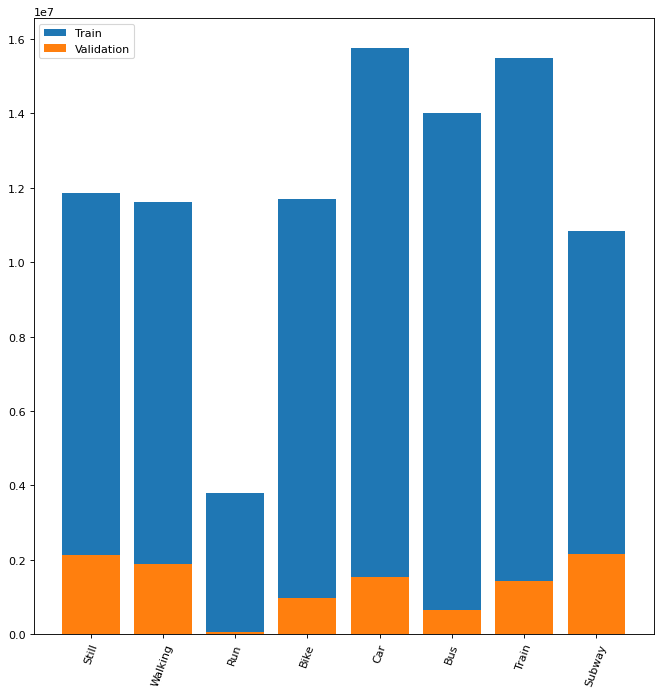

In [14]:
plt.figure(figsize=(10, 10), dpi=80)

# unique, counts = np.unique(labels, return_counts=True)
# plt.bar(CLASS_LABELS[unique], counts)
# plt.xticks(rotation=70)

unique, counts = np.unique(y_train, return_counts=True)
print(counts)
print(type(unique[0]))
plt.bar(CLASS_LABELS[unique], counts)
plt.xticks(rotation=70)

# unique, counts = np.unique(y_test, return_counts=True)
# plt.bar(CLASS_LABELS[unique], counts)
# plt.xticks(rotation=70)

unique, counts = np.unique(y_val, return_counts=True)
print(counts)
plt.bar(CLASS_LABELS[unique], counts)
plt.xticks(rotation=70)

# plt.legend(["All", "Train", "Test", "Validation"])
plt.legend(["Train", "Validation"])

plt.show()

In [15]:
def generate_arrays(x, y, batch_size=32):
    i = 0
    while True:
        batch_X = x[i * batch_size : (i + 1) * batch_size]
        batch_y = y[i * batch_size : (i + 1) * batch_size]
        if (i + 1) * batch_size >= len(x):
            i = 0 # iのリセットは必要
        else:
            i += 1
        yield process_data(batch_X, batch_y)
        
        
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y
    
def process_data(batch_X, batch_y):
    # arr = {}   
    # # パディングして履歴の長さをそろえる
    # for c in batch_df.columns:
    #     arr[c] = pad_sequences(batch_df[c], dtype='float32', maxlen=MAX_RES_TOKENS)

    return (batch_X, batch_y)

In [16]:
def train(config=None):
  # with wandb.init(config=config):
  #   config = wandb.config
    # Generate new model  
    model = Transformer(
      num_layers=config.num_layers,
      embed_dim=config.embed_layer_size,
      mlp_dim=config.fc_layer_size,
      num_heads=config.num_heads,
      num_classes=8,
      dropout_rate=config.dropout,
      attention_dropout_rate=config.attention_dropout,
    )
    generator_train = DataGenerator(X_train,y_train,batch_size=config.batch_size)
    generator_val = DataGenerator(X_val,y_val,batch_size=config.batch_size)
    checkpoint_path = os.path.join(OUTPUT_DIR,MODEL_OUT,"cp-{epoch:04d}.ckpt")
    checkpoint_dir = os.path.dirname(checkpoint_path)
    # adapt on training dataset - must be before model.compile !!!
    model.input_norm.adapt(X_train, batch_size=config.batch_size)
    print(model.input_norm.variables)

    # Select optimizer
    if config.optimizer == "adam":
      optim = Adam(
          global_clipnorm=config.global_clipnorm,
          amsgrad=config.amsgrad,
      )
    elif config.optimizer == "adamw":
      optim = AdamW(
          weight_decay=config.weight_decay,
          amsgrad=config.amsgrad,
          global_clipnorm=config.global_clipnorm,
          exclude_from_weight_decay=["position"]
      )
    else:
      raise ValueError("The used optimizer is not in list of available")

    model.compile(
      loss=smoothed_sparse_categorical_crossentropy(label_smoothing=config.label_smoothing),
      optimizer=optim,
      metrics=["accuracy"],
    )
    model.build(input_shape=(config.batch_size,500,9))
    # model.load_weights(os.path.join(OUTPUT_DIR,'0531.data-00000-of-00001'))
    # Train model
    
      # model.fit(
      #   X_train,
      #   y_train,
      #   batch_size=config.batch_size,
      #   epochs=config.epochs,
      #   validation_data=(X_val, y_val),
      #   steps_per_epoch=config.steps_per_epoch
      #   callbacks=[
      #     LearningRateScheduler(cosine_schedule(base_lr=config.learning_rate, total_steps=config.epochs, warmup_steps=config.warmup_steps)),
      #     # PrintLR(),
      #     ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1),
      #     # WandbCallback(monitor="val_accuracy", mode='max', save_weights_only=True),
      #     EarlyStopping(monitor="val_accuracy", mode='max', min_delta=0.001, patience=5),
      #   ],
      #   verbose=1
      # )
      # 一度にメモリに乗せるデータ
      model.fit(
          generator_train,
          validation_data=generator_val,
          epochs=config.epochs,
          steps_per_epoch=len(X_train) // config.batch_size,
          validation_steps=len(X_val) // config.batch_size,
          callbacks=[
          LearningRateScheduler(cosine_schedule(base_lr=config.learning_rate, total_steps=config.epochs, warmup_steps=config.warmup_steps)),
          # PrintLR(),
          ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1),
          # WandbCallback(monitor="val_accuracy", mode='max', save_weights_only=True),
          EarlyStopping(monitor="val_accuracy", mode='max', min_delta=0.001, patience=5),
        ],
        verbose=1
      )
    except Exception as e:
      print(e)
      del model
  
    # plot_model(
    # model,
    # show_shapes=True,
    # )
    model.summary()

In [17]:
class config:
  epochs=50
  num_layers=3
  # embed_layer_size=96
  embed_layer_size=128
  fc_layer_size=256
  # num_heads=6
  num_heads=6
  dropout=0.2
  attention_dropout=0.2
  optimizer='adamw'
  amsgrad=False
  label_smoothing=0.1
  learning_rate=1e-4
  weight_decay=5e-5
  warmup_steps=10
  batch_size=32
  global_clipnorm=3.0

In [18]:
train(config=config)

[<tf.Variable 'mean:0' shape=(9,) dtype=float32, numpy=
array([-8.7519389e-01, -6.0505122e-02, -4.0406590e+00,  3.0122532e-03,
       -8.3216961e-04, -4.0412671e-03,  1.5119601e+00, -3.8158035e-01,
        1.0203282e+01], dtype=float32)>, <tf.Variable 'variance:0' shape=(9,) dtype=float32, numpy=
array([3.60271568e+01, 3.05202122e+01, 4.26727791e+01, 1.23518777e+00,
       1.24649918e+00, 8.31556261e-01, 1.01520715e+03, 1.05609973e+03,
       1.22910986e+03], dtype=float32)>, <tf.Variable 'count:0' shape=() dtype=int64, numpy=95018500>]
Epoch 1/50
5938/5938 [==============================] - ETA: 0s - loss: 1.9369 - accuracy: 0.2962
Epoch 1: saving model to ../output/model/transformer/0606\cp-0001.ckpt
5938/5938 [==============================] - 991s 166ms/step - loss: 1.9369 - accuracy: 0.2962 - val_loss: 1.9348 - val_accuracy: 0.0851 - lr: 1.0000e-05
Epoch 2/50
5938/5938 [==============================] - ETA: 0s - loss: 1.7210 - accuracy: 0.3507
Epoch 2: saving model to ../output/m

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param    
=================================================================
 normalization (Normalizatio  multiple                 19        n)                                                              
                                                                 
 positional_embedding (Posit  multiple                 65280     
 ionalEmbedding)                                                 
                                                                 
 encoder (Encoder)           multiple                  396160    
                                                                 
 encoder_1 (Encoder)         multiple                  396160    
                                                                 
 encoder_2 (Encoder)         multiple                  396160    
                                                                 
 layer_normalization_6 (Laye  multiple                 256       
 rNormalization)                                                 
                                                                 
 dense_7 (Dense)             multiple                  2322      
                                                                 
=================================================================
Total params: 1,256,357
Trainable params: 1,256,338
Non-trainable params: 19
_________________________________________________________________

In [19]:

config.num_layers

3

In [20]:
tf.keras.backend.clear_session()

In [21]:
%load_ext tensorboard

In [22]:
import multiprocessing

process_eval = multiprocessing.Process(target=train, args=(config))
process_eval.start()
process_eval.join()

TypeError: 'type' object is not iterable